# Catalog Enrichment

E-Commerce search and ads benefit a lot from offline catalog enrichment. The input text and image can be parsed to extract attributes and values. These attributes often act as facets. 

## Inspiration

> Walmart used LLMs to improve 850m piece of data in their product catalogs, something that would have taken them 100x the headcount / time to do without LLMs
>
> ![](../../images/walmart-example.png)
>
> Source: [https://x.com/tanayj/status/1832237013220913369](https://x.com/tanayj/status/1832237013220913369)


## Concepts

1. **Pixtral**: Pixtral is a multimodal, multi-lingual model. It particularly shines at working with images and text. It is Mistral's `pixtral-12b-2409` model.
1. **Multi-modal** by default: Pixtral is a multimodal model that can take in images and text as input.
1. **JSON response formatting**: We will use the JSON response formatting to extract attributes and values from the image and text.
1. **Schema-less**: The attributes and values are not predefined by code. They are extracted from the image and text by the model.
1. **French translation**: We will use Mistral's French translation capabilities to translate the values to French.


In [50]:
!pip install uv
!uv pip install mistralai==1.2.5 datasets==2.14.5 python-dotenv==1.0.0 pillow==10.0.1 -q

In [33]:
import base64
from mistralai import Mistral
from dotenv import load_dotenv
from pathlib import Path
from PIL import Image
import os
from io import BytesIO
from datasets import load_dataset
from IPython.display import display, Image as IPythonImage
from rich import print

load_dotenv()
PathLike = Path | str

In [21]:
# Retrieve the API key from environment variables
api_key = os.environ["MISTRAL_API_KEY"]

# Specify model
model = "pixtral-12b-2409"

# Initialize the Mistral client
client = Mistral(api_key=api_key)

# Get the dataset

We are using a Fashion dataset from Hugging Face Datasets. We will use the first 1000 samples.

In [22]:
ds = load_dataset("tomytjandra/h-and-m-fashion-caption", split="train")

In [23]:
# Choose the first 1000 samples
ds = ds.select(range(1000))


In [24]:
def encode_pil_to_base64(pil_image):
    """
    Convert a PIL Image to base64 encoded string.

    Args:
        pil_image: PIL Image object

    Returns:
        str: base64 encoded string of the image
    """
    # Create a bytes buffer to hold the image data
    buffered = BytesIO()

    # Save the image to the buffer in JPEG format
    # You can adjust format and quality as needed
    pil_image.save(buffered, format="JPEG", quality=95)

    # Get the bytes from the buffer
    img_bytes = buffered.getvalue()

    # Encode to base64 and convert to string
    img_base64 = base64.b64encode(img_bytes).decode("utf-8")

    return f"data:image/jpeg;base64,{img_base64}"

In [42]:

def display_record(record):
    """
    Display a PIL Image inline in Jupyter notebook.
    
    Args:
        pil_image: PIL Image object
    """
    # Create a bytes buffer
    buffered = BytesIO()
    pil_image = record["image"]
    # Save the image to the buffer
    pil_image.save(buffered, format="JPEG")
    
    # Create IPython image object
    ipython_image = IPythonImage(data=buffered.getvalue())
    
    # Display inline
    display(ipython_image), print(record["text"])

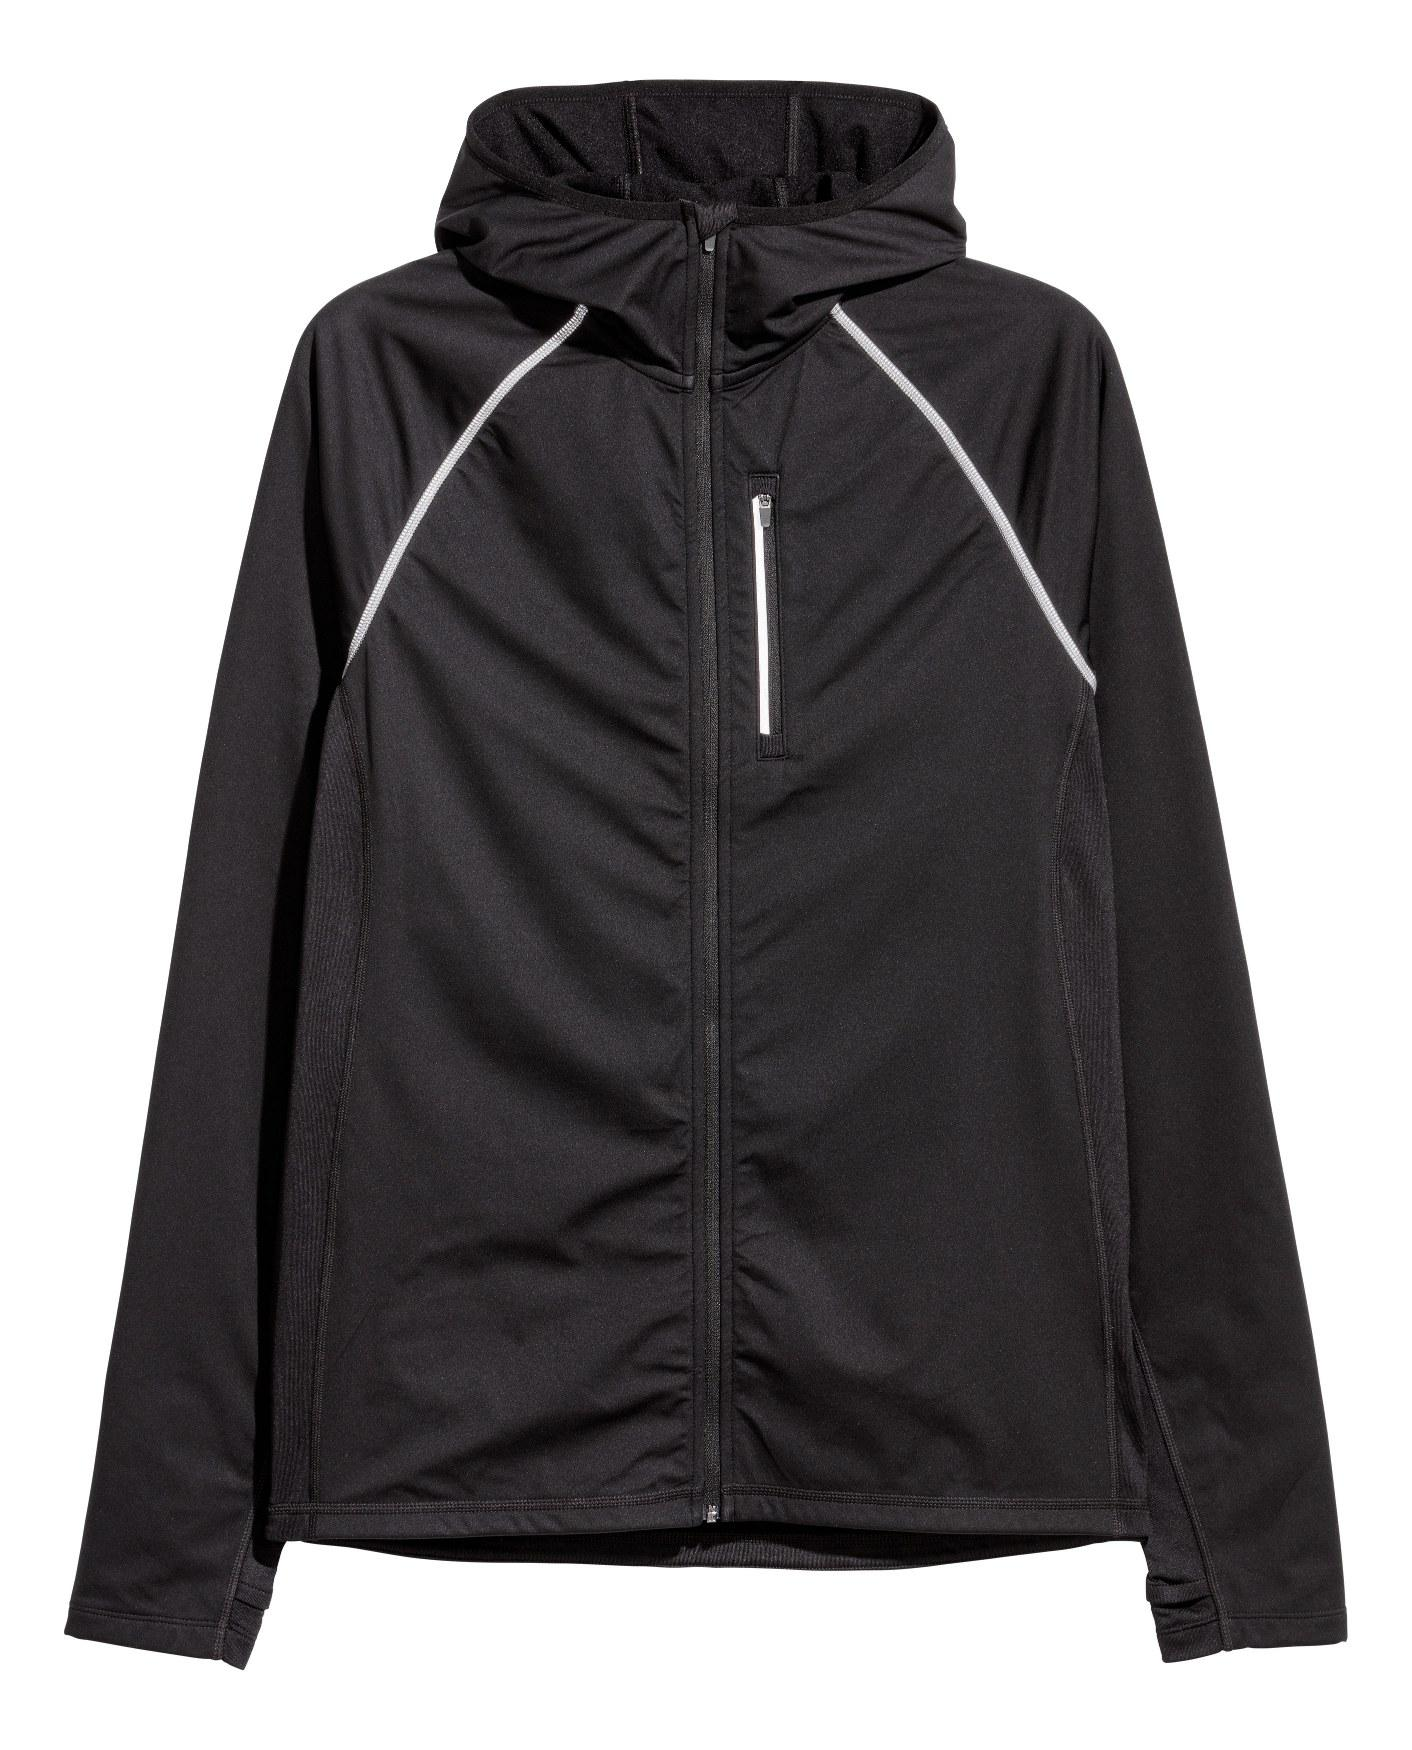

solid black running jacket with front and shoulder sections in windproof functional fabric ventilating mesh 
sections in the sides a small stand-up collar and zip down the front thumbholes at the cuffs reflective details and
a rounded hem slightly longer at the back brushed thermal inside tight fit

```json
{
  "attributes": [
    {
      "attribute": "Color",
      "values": ["Noir"]
    },
    {
      "attribute": "Material",
      "values": ["Tissu fonctionnel imperméable", "Maille ventilante"]
    },
    {
      "attribute": "Collar",
      "values": ["Col rond dégagé"]
    },
    {
      "attribute": "Closure",
      "values": ["Zip avant"]
    },
    {
      "attribute": "Cuffs",
      "values": ["Guêtres avec orifices pour pouces"]
    },
    {
      "attribute": "Details",
      "values": ["Détails réfléchissants"]
    },
    {
      "attribute": "Hem",
      "values": ["Ourlet arrondi légèrement plus long à l'arrière"]
    },
    {
      "attribute": "Lining",
      "values": ["Intérieur thermoformé"]
    },
    {
      "attribute": "Fit",
      "values": ["Slim fit"]
    }
  ]
}
```

In [46]:
def prepare_messages(record, language="en"):
    messages = [
        {
            "role": "system",
            "content": "Return the answer in a JSON object with the next structure: "
            '{"attributes": [{"attribute": "some name of attribute1 in English", '
            '"values": ["some value of attribute 1", "some value of attribute 1"]}, '
            '{"attribute": "some name of attribute2 in English", "values": '
            '["some value of attribute 2", "some value of attribute 2"]}]}',
        },
        {
            "role": "user",
            "content": f"Describe the image and text for an e-commerce catalog. Include all the attributes and values that are present in the image. For instance, collar, sleeves, etc. Use English attributes and {language} values.",
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": encode_pil_to_base64(record["image"]),
                }
            ],
        },
        {
            "role": "user",
            "content": record["text"],
        },
    ]
    return messages


record = ds[37]
display_record(record)

# Get the chat response
chat_response = client.chat.complete(model=model, messages=prepare_messages(record, language="french"))

# Print the content of the response
print(chat_response.choices[0].message.content)